## Project 6: Analyzing Stock Sentiment from Twits

In [1]:
import json
import nltk
import os
import random
import re
import torch

from torch import nn, optim
import torch.nn.functional as F

## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain. You want to be able to turn this information into a signal. Currently, the best tool for the job is a Neural Network. 

For this project, you'll use posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. You'll build a model around these twits that generate a sentiment score.

We've collected a bunch of twits, then hand labeled the sentiment of each. To capture the degree of sentiment, we'll use a five-point scale: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. You'll build a sentiment analysis model that will learn to assign sentiment to twits on its own, using this labeled data.

The first thing we should to do, is load the data.

## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral.


To see what the data look like by printing the first 10 twits from the list. 

In [2]:
with open('twits.json') as f:
    twits = json.load(f)

twits['data'][:5]

[{'message_body': '$FITB great buy at 26.00...ill wait',
  'sentiment': 2,
  'timestamp': '2018-07-01T00:00:09Z'},
 {'message_body': '@StockTwits $MSFT',
  'sentiment': 1,
  'timestamp': '2018-07-01T00:00:42Z'},
 {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating',
  'sentiment': 2,
  'timestamp': '2018-07-01T00:01:24Z'},
 {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.',
  'sentiment': 1,
  'timestamp': '2018-07-01T00:01:47Z'},
 {'message_body': '$AMD reveal yourself!',
  'sentiment': 0,
  'timestamp': '2018-07-01T00:02:13Z'}]

## Length of Data


In [3]:
len(twits['data'])

1548010

## Split Message Body and Sentiment Score

In [4]:
messages = [twit['message_body'] for twit in twits['data']]
#score was from -2 to 2, we'll scale the sentiments to 0 to 4 for our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]
#the +2 will turn -2 into 0

In [5]:
sentiments[:40]

[4,
 3,
 4,
 3,
 2,
 3,
 0,
 3,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 3,
 4,
 2,
 4,
 3,
 3,
 3,
 0,
 1,
 2,
 3,
 3,
 0,
 4,
 2,
 4,
 0,
 3,
 2,
 2,
 1,
 2,
 2,
 3,
 2]

### Pre-Processing

In [6]:
nltk.download('wordnet')

def preprocess(message):
  
    text = message.lower()
    
    text = re.sub(r'https?://[^\s]+', ' ', text)
    
    text = re.sub(r'\$[a-zA-Z0-9]*', ' ', text)
    
    text = re.sub(r'@[a-zA-Z0-9]*', ' ', text)

    text = re.sub(r'[^a-z]', ' ', text)
    
    tokens = text.split()


    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(w) for w in tokens if len(w)>1]
    
    return tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Preprocess All the Twits 
Now we can preprocess each of the twits in our dataset. Apply the function `preprocess` to all the twit messages.

In [8]:
import pickle
with open ('P6_tokenized.p','rb')as f:
    tokenized=pickle.load(f)

In [10]:
messages[0]

'$FITB great buy at 26.00...ill wait'

In [11]:
tokenized[0]

['great', 'buy', 'at', 'ill', 'wait']

## filter away empty tokenized twit and label

In [12]:
print("Number of tokens before removing empty ones: {}".format(len(tokenized)))

Number of tokens before removing empty ones: 1548010


In [13]:
good_tokens = [idx for idx, token in enumerate(tokenized) if len(token) > 0]
tokenized = [tokenized[idx] for idx in good_tokens]
sentiments = [sentiments[idx] for idx in good_tokens]


In [14]:
print("Number of tokens after removing empty ones: {}".format(len(good_tokens)))

Number of tokens after removing empty ones: 1499486


In [15]:
total_words = [word for twit in tokenized for word in twit]

total_words

['great',
 'buy',
 'at',
 'ill',
 'wait',
 'staanalystalert',
 'for',
 'jefferies',
 'maintains',
 'with',
 'rating',
 'of',
 'hold',
 'setting',
 'target',
 'price',
 'at',
 'usd',
 'our',
 'own',
 'verdict',
 'is',
 'buy',
 'heard',
 'there',
 'guy',
 'who',
 'know',
 'someone',
 'who',
 'think',
 'somebody',
 'know',
 'something',
 'on',
 'stocktwits',
 'reveal',
 'yourself',
 'why',
 'the',
 'drop',
 'warren',
 'buffet',
 'taking',
 'out',
 'his',
 'position',
 'bear',
 'have',
 'reason',
 'on',
 'to',
 'pay',
 'more',
 'attention',
 'ok',
 'good',
 'we',
 're',
 'not',
 'dropping',
 'in',
 'price',
 'over',
 'the',
 'weekend',
 'lol',
 'daily',
 'chart',
 'we',
 'need',
 'to',
 'get',
 'back',
 'to',
 'above',
 'drop',
 'per',
 'week',
 'after',
 'spike',
 'if',
 'no',
 'news',
 'in',
 'month',
 'back',
 'to',
 'if',
 'bo',
 'then',
 'bingo',
 'what',
 'is',
 'the',
 'odds',
 'strong',
 'buy',
 'short',
 'ratio',
 'is',
 'at',
 'and',
 'short',
 'to',
 'float',
 'is',
 'via',
 'pr

## Filter away stop words

In [16]:
from nltk.corpus import stopwords
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
print(f'before removing stop words there are {len(total_words)} words')

before removing stop words there are 15544613 words


In [19]:
import pickle
with open ('P6_text_after_stop_words.p','rb')as f:
    text_clean=pickle.load(f)

In [20]:
print(f'after removing stop words there are {len(text_clean)} words')

after removing stop words there are 9820800 words


In [21]:
len(text_clean)/len(total_words)

0.6317815696022796

## Bag of Words
we want to create a vocabulary and count up how often each word appears in our entire corpus. Use the [`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter) function to count up all the tokens.

In [23]:
from collections import Counter
bow = Counter(text_clean)
bow


Counter({'great': 17574,
         'buy': 76326,
         'ill': 883,
         'wait': 11370,
         'staanalystalert': 4072,
         'jefferies': 1056,
         'maintains': 903,
         'rating': 15436,
         'hold': 22152,
         'setting': 3889,
         'target': 16580,
         'price': 37083,
         'usd': 2955,
         'verdict': 3736,
         'heard': 1357,
         'guy': 13433,
         'know': 19936,
         'someone': 5192,
         'think': 24284,
         'somebody': 1100,
         'something': 6010,
         'stocktwits': 1439,
         'reveal': 196,
         'drop': 17793,
         'warren': 1015,
         'buffet': 1301,
         'taking': 6418,
         'position': 11753,
         'bear': 33566,
         'reason': 7777,
         'pay': 7609,
         'attention': 3531,
         'ok': 4567,
         'good': 44208,
         'dropping': 2269,
         'weekend': 3561,
         'lol': 30941,
         'daily': 14035,
         'chart': 16004,
         'need':

## Filter away too frequent/rare  Words in Message
- remove some of the most common words such as 'the', 'and', 'it', etc. These words don't contribute to identifying sentiment and are really common, resulting in a lot of noise in our input. 
- If we can filter these out, then our network should have an easier time learning.

- We also want to remove really rare words that show up in a only a few twits. 
- Here you'll want to divide the count of each word by the number of messages. Then remove words that only appear in some small fraction of the messages.

### Since already remove stopwords, may not need to remove most frequent words

In [24]:
total_num_words = len(text_clean)


freqs = {key: value/total_num_words for key, value in bow.items()}


low_cutoff = 5e-6


high_cutoff = 15

freqs

{'great': 0.0017894672531769307,
 'buy': 0.007771871945259042,
 'ill': 8.991120886282177e-05,
 'wait': 0.0011577468230694037,
 'staanalystalert': 0.0004146301726946888,
 'jefferies': 0.00010752688172043011,
 'maintains': 9.194770283479962e-05,
 'rating': 0.0015717660475724992,
 'hold': 0.0022556207233626587,
 'setting': 0.00039599625285109154,
 'target': 0.0016882535027696317,
 'price': 0.0037759652981427176,
 'usd': 0.0003008919843597263,
 'verdict': 0.00038041707396546106,
 'heard': 0.00013817611599869665,
 'guy': 0.0013678111762789181,
 'know': 0.002029977191267514,
 'someone': 0.0005286738351254481,
 'think': 0.0024727109807754968,
 'somebody': 0.00011200716845878136,
 'something': 0.0006119664385793418,
 'stocktwits': 0.0001465257412838058,
 'reveal': 1.995764092538286e-05,
 'drop': 0.001811766862170088,
 'warren': 0.00010335206907787554,
 'buffet': 0.0001324739328771587,
 'taking': 0.0006535109156076898,
 'position': 0.0011967456826327794,
 'bear': 0.0034178478331704136,
 'reason

In [25]:
K_most_common = [word[0] for word in bow.most_common(high_cutoff)]


In [26]:
bow.most_common(high_cutoff)


[('short', 86672),
 ('buy', 76326),
 ('today', 76250),
 ('stock', 75468),
 ('call', 67770),
 ('day', 67492),
 ('report', 55268),
 ('wa', 55257),
 ('market', 53676),
 ('earnings', 52932),
 ('go', 52769),
 ('estimize', 52763),
 ('like', 51922),
 ('analyst', 49821),
 ('trade', 49537)]

In [27]:
[word[0] for word in bow.most_common(high_cutoff)]

['short',
 'buy',
 'today',
 'stock',
 'call',
 'day',
 'report',
 'wa',
 'market',
 'earnings',
 'go',
 'estimize',
 'like',
 'analyst',
 'trade']

In [29]:
filtered_words = [word for word in freqs if (freqs[word] > low_cutoff)]

print(K_most_common)
print(len(filtered_words))

filtered_words

['short', 'buy', 'today', 'stock', 'call', 'day', 'report', 'wa', 'market', 'earnings', 'go', 'estimize', 'like', 'analyst', 'trade']
8311


['great',
 'buy',
 'ill',
 'wait',
 'staanalystalert',
 'jefferies',
 'maintains',
 'rating',
 'hold',
 'setting',
 'target',
 'price',
 'usd',
 'verdict',
 'heard',
 'guy',
 'know',
 'someone',
 'think',
 'somebody',
 'something',
 'stocktwits',
 'reveal',
 'drop',
 'warren',
 'buffet',
 'taking',
 'position',
 'bear',
 'reason',
 'pay',
 'attention',
 'ok',
 'good',
 'dropping',
 'weekend',
 'lol',
 'daily',
 'chart',
 'need',
 'get',
 'back',
 'per',
 'week',
 'spike',
 'news',
 'month',
 'bo',
 'bingo',
 'odds',
 'strong',
 'short',
 'ratio',
 'float',
 'via',
 'squeezing',
 'perfect',
 'place',
 'option',
 'straddle',
 'near',
 'supporting',
 'trend',
 'start',
 'new',
 'monday',
 'expect',
 'volume',
 'across',
 'key',
 'company',
 'various',
 'sector',
 'breakout',
 'strategy',
 'current',
 'portfolio',
 'bull',
 'catalyst',
 'continuing',
 'uptrend',
 'pill',
 'pack',
 'amazon',
 'prime',
 'day',
 'earnings',
 'test',
 'break',
 'soon',
 'ha',
 'moved',
 'check',
 'movement',
 

## Updating Vocabulary by Removing Filtered Words

In [30]:
vocab = {word: i for i, word in enumerate(filtered_words,1)}

vocab

{'great': 1,
 'buy': 2,
 'ill': 3,
 'wait': 4,
 'staanalystalert': 5,
 'jefferies': 6,
 'maintains': 7,
 'rating': 8,
 'hold': 9,
 'setting': 10,
 'target': 11,
 'price': 12,
 'usd': 13,
 'verdict': 14,
 'heard': 15,
 'guy': 16,
 'know': 17,
 'someone': 18,
 'think': 19,
 'somebody': 20,
 'something': 21,
 'stocktwits': 22,
 'reveal': 23,
 'drop': 24,
 'warren': 25,
 'buffet': 26,
 'taking': 27,
 'position': 28,
 'bear': 29,
 'reason': 30,
 'pay': 31,
 'attention': 32,
 'ok': 33,
 'good': 34,
 'dropping': 35,
 'weekend': 36,
 'lol': 37,
 'daily': 38,
 'chart': 39,
 'need': 40,
 'get': 41,
 'back': 42,
 'per': 43,
 'week': 44,
 'spike': 45,
 'news': 46,
 'month': 47,
 'bo': 48,
 'bingo': 49,
 'odds': 50,
 'strong': 51,
 'short': 52,
 'ratio': 53,
 'float': 54,
 'via': 55,
 'squeezing': 56,
 'perfect': 57,
 'place': 58,
 'option': 59,
 'straddle': 60,
 'near': 61,
 'supporting': 62,
 'trend': 63,
 'start': 64,
 'new': 65,
 'monday': 66,
 'expect': 67,
 'volume': 68,
 'across': 69,
 'key'

In [31]:
len(vocab)


8311

In [32]:
id2vocab = {i: word for i, word in enumerate(filtered_words)}
id2vocab

{0: 'great',
 1: 'buy',
 2: 'ill',
 3: 'wait',
 4: 'staanalystalert',
 5: 'jefferies',
 6: 'maintains',
 7: 'rating',
 8: 'hold',
 9: 'setting',
 10: 'target',
 11: 'price',
 12: 'usd',
 13: 'verdict',
 14: 'heard',
 15: 'guy',
 16: 'know',
 17: 'someone',
 18: 'think',
 19: 'somebody',
 20: 'something',
 21: 'stocktwits',
 22: 'reveal',
 23: 'drop',
 24: 'warren',
 25: 'buffet',
 26: 'taking',
 27: 'position',
 28: 'bear',
 29: 'reason',
 30: 'pay',
 31: 'attention',
 32: 'ok',
 33: 'good',
 34: 'dropping',
 35: 'weekend',
 36: 'lol',
 37: 'daily',
 38: 'chart',
 39: 'need',
 40: 'get',
 41: 'back',
 42: 'per',
 43: 'week',
 44: 'spike',
 45: 'news',
 46: 'month',
 47: 'bo',
 48: 'bingo',
 49: 'odds',
 50: 'strong',
 51: 'short',
 52: 'ratio',
 53: 'float',
 54: 'via',
 55: 'squeezing',
 56: 'perfect',
 57: 'place',
 58: 'option',
 59: 'straddle',
 60: 'near',
 61: 'supporting',
 62: 'trend',
 63: 'start',
 64: 'new',
 65: 'monday',
 66: 'expect',
 67: 'volume',
 68: 'across',
 69: 'k

In [33]:
filtered = [ [w for w in twit if w in vocab] for twit in tokenized ]


In [34]:
tokenized[:2]

[['great', 'buy', 'at', 'ill', 'wait'],
 ['staanalystalert',
  'for',
  'jefferies',
  'maintains',
  'with',
  'rating',
  'of',
  'hold',
  'setting',
  'target',
  'price',
  'at',
  'usd',
  'our',
  'own',
  'verdict',
  'is',
  'buy']]

In [35]:
len(filtered)


1499486

In [36]:
filtered

[['great', 'buy', 'ill', 'wait'],
 ['staanalystalert',
  'jefferies',
  'maintains',
  'rating',
  'hold',
  'setting',
  'target',
  'price',
  'usd',
  'verdict',
  'buy'],
 ['heard',
  'guy',
  'know',
  'someone',
  'think',
  'somebody',
  'know',
  'something',
  'stocktwits'],
 ['reveal'],
 ['drop', 'warren', 'buffet', 'taking', 'position'],
 ['bear', 'reason', 'pay', 'attention'],
 ['ok', 'good', 'dropping', 'price', 'weekend', 'lol'],
 ['daily', 'chart', 'need', 'get', 'back'],
 ['drop',
  'per',
  'week',
  'spike',
  'news',
  'month',
  'back',
  'bo',
  'bingo',
  'odds'],
 ['strong', 'buy'],
 ['short', 'ratio', 'short', 'float', 'via'],
 ['price',
  'squeezing',
  'perfect',
  'place',
  'option',
  'straddle',
  'near',
  'supporting',
  'trend'],
 ['start',
  'new',
  'monday',
  'expect',
  'strong',
  'buy',
  'volume',
  'across',
  'key',
  'company',
  'various',
  'sector'],
 ['breakout', 'strategy', 'current', 'portfolio'],
 ['bull', 'reason', 'pay', 'attention']

## Balancing the classes
- Let's do a few last pre-processing steps. we find that 50% of the twit are label as neutral. 
- This means that our network will be 50% accurate just by guessing 0 every single time.
- We should balance our classes to help our model learn.
- We make sure each of our different sentiment scores show up roughly as frequently in the data.
- What can go through each of our examples and randomly drop twits with neutral sentiment. 
- What should be the probability we drop these twits if we want to get around 20% neutral twits from 50% neutral? We should also take this opportunity to remove messages with length 0.

In [37]:
n_neutral = sum(1 for each in sentiments if each == 2)

n_neutral



668185

In [38]:
sentiments

[4,
 4,
 3,
 2,
 3,
 0,
 3,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 3,
 4,
 2,
 4,
 3,
 3,
 3,
 0,
 1,
 2,
 3,
 3,
 0,
 4,
 2,
 4,
 0,
 3,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 2,
 2,
 4,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 1,
 4,
 3,
 4,
 0,
 3,
 2,
 0,
 2,
 1,
 4,
 1,
 3,
 2,
 4,
 1,
 2,
 0,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 4,
 2,
 3,
 4,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 3,
 2,
 0,
 2,
 0,
 4,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 4,
 0,
 4,
 3,
 3,
 2,
 2,
 4,
 2,
 4,
 2,
 2,
 1,
 1,
 4,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 4,
 1,
 2,
 2,
 2,
 0,
 3,
 0,
 4,
 2,
 2,
 4,
 3,
 2,
 2,
 3,
 1,
 2,
 2,
 4,
 2,
 1,
 2,
 2,
 3,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 3,
 2,
 3,
 0,
 4,
 2,
 4,
 2,
 4,
 1,
 0,
 2,
 1,
 3,
 2,
 4,
 2,
 1,
 4,
 3,
 0,
 3,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 2,
 4,
 1,
 1,
 3,
 2,
 2,
 0,
 3,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 4,
 2,
 2,
 3,
 0,
 3,
 1,
 3,
 3,
 3,
 4,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 0,
 3,


In [39]:
N_examples = len(sentiments)
keep_prob = (N_examples - n_neutral)/4/n_neutral
keep_prob

0.31102950530167545

In [41]:
filtered


[['great', 'buy', 'ill', 'wait'],
 ['staanalystalert',
  'jefferies',
  'maintains',
  'rating',
  'hold',
  'setting',
  'target',
  'price',
  'usd',
  'verdict',
  'buy'],
 ['heard',
  'guy',
  'know',
  'someone',
  'think',
  'somebody',
  'know',
  'something',
  'stocktwits'],
 ['reveal'],
 ['drop', 'warren', 'buffet', 'taking', 'position'],
 ['bear', 'reason', 'pay', 'attention'],
 ['ok', 'good', 'dropping', 'price', 'weekend', 'lol'],
 ['daily', 'chart', 'need', 'get', 'back'],
 ['drop',
  'per',
  'week',
  'spike',
  'news',
  'month',
  'back',
  'bo',
  'bingo',
  'odds'],
 ['strong', 'buy'],
 ['short', 'ratio', 'short', 'float', 'via'],
 ['price',
  'squeezing',
  'perfect',
  'place',
  'option',
  'straddle',
  'near',
  'supporting',
  'trend'],
 ['start',
  'new',
  'monday',
  'expect',
  'strong',
  'buy',
  'volume',
  'across',
  'key',
  'company',
  'various',
  'sector'],
 ['breakout', 'strategy', 'current', 'portfolio'],
 ['bull', 'reason', 'pay', 'attention']

In [42]:
balanced = {'messages': [], 'sentiments':[]}

for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    
    if len(message) == 0:

        continue
    elif sentiment != 2 or random.random() < keep_prob:

        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 

In [43]:
balanced

{'messages': [['great', 'buy', 'ill', 'wait'],
  ['staanalystalert',
   'jefferies',
   'maintains',
   'rating',
   'hold',
   'setting',
   'target',
   'price',
   'usd',
   'verdict',
   'buy'],
  ['heard',
   'guy',
   'know',
   'someone',
   'think',
   'somebody',
   'know',
   'something',
   'stocktwits'],
  ['drop', 'warren', 'buffet', 'taking', 'position'],
  ['bear', 'reason', 'pay', 'attention'],
  ['ok', 'good', 'dropping', 'price', 'weekend', 'lol'],
  ['daily', 'chart', 'need', 'get', 'back'],
  ['drop',
   'per',
   'week',
   'spike',
   'news',
   'month',
   'back',
   'bo',
   'bingo',
   'odds'],
  ['strong', 'buy'],
  ['short', 'ratio', 'short', 'float', 'via'],
  ['price',
   'squeezing',
   'perfect',
   'place',
   'option',
   'straddle',
   'near',
   'supporting',
   'trend'],
  ['start',
   'new',
   'monday',
   'expect',
   'strong',
   'buy',
   'volume',
   'across',
   'key',
   'company',
   'various',
   'sector'],
  ['breakout', 'strategy', 'curre

In [44]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
print(n_neutral)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

204695


0.19861229970910882

## Convert vocab tokens into integer

In [45]:
balanced['messages']

[['great', 'buy', 'ill', 'wait'],
 ['staanalystalert',
  'jefferies',
  'maintains',
  'rating',
  'hold',
  'setting',
  'target',
  'price',
  'usd',
  'verdict',
  'buy'],
 ['heard',
  'guy',
  'know',
  'someone',
  'think',
  'somebody',
  'know',
  'something',
  'stocktwits'],
 ['drop', 'warren', 'buffet', 'taking', 'position'],
 ['bear', 'reason', 'pay', 'attention'],
 ['ok', 'good', 'dropping', 'price', 'weekend', 'lol'],
 ['daily', 'chart', 'need', 'get', 'back'],
 ['drop',
  'per',
  'week',
  'spike',
  'news',
  'month',
  'back',
  'bo',
  'bingo',
  'odds'],
 ['strong', 'buy'],
 ['short', 'ratio', 'short', 'float', 'via'],
 ['price',
  'squeezing',
  'perfect',
  'place',
  'option',
  'straddle',
  'near',
  'supporting',
  'trend'],
 ['start',
  'new',
  'monday',
  'expect',
  'strong',
  'buy',
  'volume',
  'across',
  'key',
  'company',
  'various',
  'sector'],
 ['breakout', 'strategy', 'current', 'portfolio'],
 ['bull', 'reason', 'pay', 'attention'],
 ['catalyst

In [46]:
token_ids = [[vocab[word] for word in twit] for twit in balanced['messages']]

token_ids

[[1, 2, 3, 4],
 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 2],
 [15, 16, 17, 18, 19, 20, 17, 21, 22],
 [24, 25, 26, 27, 28],
 [29, 30, 31, 32],
 [33, 34, 35, 12, 36, 37],
 [38, 39, 40, 41, 42],
 [24, 43, 44, 45, 46, 47, 42, 48, 49, 50],
 [51, 2],
 [52, 53, 52, 54, 55],
 [12, 56, 57, 58, 59, 60, 61, 62, 63],
 [64, 65, 66, 67, 51, 2, 68, 69, 70, 71, 72, 73],
 [74, 75, 76, 77],
 [78, 30, 31, 32],
 [79, 80, 65, 81, 82, 83, 2, 84, 85, 86, 87, 88, 89, 90],
 [5, 96, 97, 98, 12, 11, 8, 2, 10, 11, 12, 13, 14, 2],
 [19, 99, 100, 101, 102, 66, 103, 76, 46, 104, 105, 106],
 [91, 76, 53, 107, 108, 91, 109, 110, 111],
 [112, 113, 114, 115, 116],
 [52],
 [117, 118, 119, 44, 120, 121],
 [76, 53, 122, 123, 124, 125],
 [126, 86],
 [89, 127, 119, 44, 128, 129, 130, 131, 2, 12],
 [29, 30, 31, 32],
 [74, 132, 133, 86, 133, 133, 133, 86],
 [140, 141, 142, 143, 140, 144, 145],
 [52, 68, 146, 140, 86, 147, 140, 148, 149],
 [150, 151, 40, 100, 152, 153],
 [52, 168, 68, 52, 169, 55],
 [172, 173, 103, 123, 91, 174, 175

In [47]:
sentiments = balanced['sentiments']
sentiments

[4,
 4,
 3,
 3,
 0,
 3,
 4,
 0,
 4,
 0,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 3,
 3,
 0,
 1,
 2,
 3,
 3,
 0,
 4,
 4,
 0,
 3,
 1,
 2,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 4,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 1,
 4,
 3,
 4,
 0,
 3,
 0,
 1,
 4,
 1,
 3,
 4,
 1,
 0,
 2,
 4,
 2,
 4,
 4,
 3,
 4,
 2,
 0,
 2,
 0,
 0,
 3,
 1,
 1,
 2,
 3,
 2,
 0,
 0,
 4,
 4,
 2,
 2,
 2,
 3,
 3,
 4,
 0,
 4,
 3,
 3,
 2,
 4,
 4,
 1,
 1,
 4,
 3,
 2,
 4,
 1,
 0,
 3,
 0,
 4,
 2,
 4,
 3,
 3,
 1,
 2,
 4,
 1,
 3,
 0,
 0,
 2,
 0,
 1,
 3,
 3,
 0,
 4,
 4,
 4,
 1,
 0,
 1,
 3,
 4,
 1,
 4,
 3,
 0,
 3,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 4,
 1,
 1,
 2,
 0,
 3,
 3,
 1,
 4,
 3,
 0,
 3,
 1,
 3,
 3,
 3,
 4,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 3,
 2,
 0,
 1,
 3,
 4,
 3,
 3,
 1,
 1,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 1,
 0,
 3,
 4,
 4,
 2,
 0,
 3,
 2,
 0,
 2,
 4,
 4,
 3,
 3,
 3,
 0,
 0,
 2,
 0,
 1,
 3,
 1,
 1,
 2,
 2,
 3,
 3,
 1,
 2,
 3,
 0,
 1,
 4,
 3,
 0,
 0,
 2,
 3,
 2,
 2,
 2,
 2,
 4,
 3,
 1,
 3,
 4,
 0,
 2,
 3,
 4,
 4,
 3,
 2,
 4,
 3,
 3,
 2,
 1,
 2,
 2,
 1,


In [48]:
len(token_ids)


1030626

## Neural Network

#### Embed -> RNN -> Dense -> Softmax
### Implement the text classifier
we use softmax instead of sigmoid. The reason we are not using sigmoid is that the output of NN is not a binary. In our network, sentiment scores have 5 possible outcomes. We are looking for an outcome with the highest probability thus softmax is a better choice.

In [49]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size        
        self.lstm_layers = lstm_layers
        self.dropout = dropout     
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)   
        
        self.lstm = nn.LSTM(input_size=embed_size, 
                            hidden_size=lstm_size,
                            num_layers=lstm_layers, 
                            batch_first=False, 
                            dropout=self.dropout)

        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(in_features=lstm_size, out_features=output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):        
        weight = next(self.parameters()).data 
 
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())        
        return hidden

    def forward(self, x, hidden_state):
        batch_size = x.size(0)
        
       
        x=x.type(torch.LongTensor).to(device)
        embeds = self.embedding(x)
        
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)

        lstm_out = lstm_out[-1, : , :]
        
        out = self.dropout(lstm_out)
        out = self.fc(out)        
        log_probs = self.logsoftmax(out)
        
        return log_probs, hidden_state

## prepare x_train, x_valid set

In [50]:
split=0.8
valid_split = int(len(token_ids) * split)

train_features = token_ids[:valid_split]
valid_features = token_ids[valid_split:]
train_labels = sentiments[:valid_split]
valid_labels = sentiments[valid_split:]

## Prepare DataLoaders and Batching
Now we should build a generator that we can use to loop through our data. It'll be more efficient if we can pass our sequences in as batches. Our input tensors should look like `(sequence_length, batch_size)`. So if our sequences are 40 tokens long and we pass in 25 sequences, then we'd have an input size of `(40, 25)`.

If we set our sequence length to 40, what do we do with messages that are more or less than 40 tokens? For messages with fewer than 40 tokens, we will pad the empty spots with zeros. We should be sure to **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of our 40 long sequence will be 0. If a message has more than 40 tokens, we'll just keep the first 40 tokens.

In [51]:
def dataloader(twit_content, labels, sequence_length=30, batch_size=32, shuffle=True):

    if shuffle:
        indices = list(range(len(twit_content)))
        random.shuffle(indices)
        twit_content = [twit_content[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(twit_content)

    for ii in range(0, total_sequences, batch_size):
        batch_twit_content = twit_content[ii: ii+batch_size]
        
        batch = torch.zeros((sequence_length, len(batch_twit_content)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_twit_content):
            token_tensor = torch.tensor(tokens)
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_twit_content)])
        
        yield batch, label_tensor

## Draw data from first batch and check the shape

In [52]:
text_batch, labels = next(iter(dataloader(train_features, train_labels, sequence_length=20, batch_size=512)))
print(text_batch.shape)
print(labels.shape)

torch.Size([20, 512])
torch.Size([512])


## Training parameter


In [53]:
vocab_size=len(vocab)+1
embed_size=1024
output_size=5
lstm_size=512
lstm_layers=2
dropout=0.1
batch_size=512

model = TextClassifier(vocab_size, embed_size, lstm_size, output_size, lstm_layers, dropout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model

TextClassifier(
  (embedding): Embedding(8312, 1024)
  (lstm): LSTM(1024, 512, num_layers=2, dropout=0.1)
  (dropout): Dropout(p=0.1)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (logsoftmax): LogSoftmax()
)

## initialize the weight and hidden state for the first time training

In [54]:
model.embedding.weight.data.uniform_(-1, 1)
hidden = model.init_hidden(batch_size) 

## fast pass the the first batch of data into our model to check if it works

In [55]:
logps, hidden = model.forward(text_batch, hidden)
logps.shape


torch.Size([512, 5])

In [56]:
logps[0]

tensor([-1.6031, -1.6131, -1.6049, -1.5777, -1.6498], device='cuda:0',
       grad_fn=<SelectBackward>)

In [74]:
model=torch.load('p6_epoch.pth')

## Train the model with data

In [76]:
epochs = 5
learning_rate = 0.001
clip = 5
print_every = 100
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

train_losses = []
valid_losses = []
valid_accuracies = []
best_val_accuracy=0
for epoch in range(epochs):
    print(f'Training with epoch {epoch + 1}')
    
    train_loss = 0
    steps = 0    

    for text_batch, labels in dataloader(train_features, train_labels, 
                                         batch_size=batch_size, sequence_length=20, 
                                         shuffle=True):
        hidden = model.init_hidden(batch_size=labels.shape[0])

        steps += 1
       
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each=each.to(device)
        
        model.zero_grad() 
        
        log_probs, hidden = model.forward(text_batch, hidden)        
        
        loss = criterion(log_probs, labels)
        
        loss.backward()  
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)  
        
        optimizer.step()
        
        train_loss += loss.item()  
        
        if steps % print_every == 0:
            model.eval()
            for text_batch, labels in dataloader(valid_features, valid_labels,
                                                batch_size=batch_size, sequence_length=20,
                                                shuffle=True):

                valid_hidden = model.init_hidden(labels.shape[0])      
                
                text_batch, labels = text_batch.to(device), labels.to(device)
                for each in valid_hidden:
                    each=each.to(device)
 
                valid_log_probs, valid_hidden = model.forward(text_batch, valid_hidden)
                valid_loss = criterion(valid_log_probs, labels)
                                
                # Accuracy
                probs = torch.exp(valid_log_probs)
                top_prob, top_class = probs.topk(1)
                equality = top_class == labels.view(*top_class.shape)
                valid_accuracy = torch.mean(equality.type(torch.FloatTensor))
                                
            train_losses.append(loss.item())
            valid_losses.append(valid_loss.item())
            valid_accuracies.append(valid_accuracy.item())

            model.train()
            current_val_accuracy=sum(valid_accuracies)/len(valid_accuracies)
            
            # Print result progress...            
            print(f'Epoch: {epoch+1} / {epochs} \tStep: {steps}',
                  f'\n  Train Loss: {loss.item():.3f}',
                  f'  Valid Loss: {valid_loss.item():.3f}',
                  f'  Valid Accuracies: {valid_accuracy.item():.3f}')
            
            if current_val_accuracy > best_val_accuracy:
                
                torch.save(model,'p6_epoch2.pth')
                best_val_accuracy=current_val_accuracy
                print("New best accuracy model is saved")


Training with epoch 1
Epoch: 1 / 5 	Step: 100 
  Train Loss: 0.620   Valid Loss: 0.897   Valid Accuracies: 0.685
New best accuracy model is saved
Epoch: 1 / 5 	Step: 200 
  Train Loss: 0.560   Valid Loss: 0.859   Valid Accuracies: 0.702
New best accuracy model is saved
Epoch: 1 / 5 	Step: 300 
  Train Loss: 0.634   Valid Loss: 0.947   Valid Accuracies: 0.675
Epoch: 1 / 5 	Step: 400 
  Train Loss: 0.564   Valid Loss: 0.870   Valid Accuracies: 0.679
Epoch: 1 / 5 	Step: 500 
  Train Loss: 0.600   Valid Loss: 0.886   Valid Accuracies: 0.656
Epoch: 1 / 5 	Step: 600 
  Train Loss: 0.635   Valid Loss: 0.940   Valid Accuracies: 0.629
Epoch: 1 / 5 	Step: 700 
  Train Loss: 0.557   Valid Loss: 0.998   Valid Accuracies: 0.642
Epoch: 1 / 5 	Step: 800 
  Train Loss: 0.582   Valid Loss: 0.982   Valid Accuracies: 0.652
Epoch: 1 / 5 	Step: 900 
  Train Loss: 0.673   Valid Loss: 0.869   Valid Accuracies: 0.695
Epoch: 1 / 5 	Step: 1000 
  Train Loss: 0.597   Valid Loss: 0.984   Valid Accuracies: 0.639
E

In [77]:
print(best_val_accuracy)

0.693708598613739


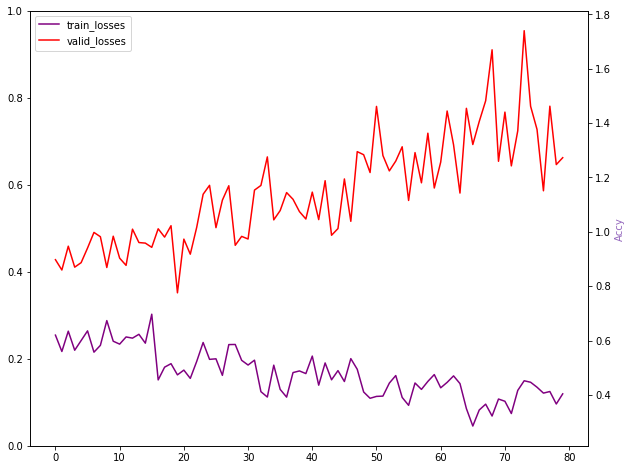

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(111)


ax2 = ax1.twinx()
ax2.set_ylabel('Accy', color='tab:purple')
ax2.plot(train_losses, label='train_losses', c='purple')
ax2.plot(valid_losses, label='valid_losses', c='red')

plt.legend()

## Making Predictions
Now we have a trained model, try it on some new twits and see if it works appropriately. Remember  need to preprocess it first before passing it to the network.

In [88]:
def predict(text, model, vocab):    
    tokens = preprocess(text)
    
    tokens = [word for word in tokens if word in filtered_words]
    tokens = [vocab[word] for word in tokens] 
        
    text_input = torch.tensor(tokens).unsqueeze(1)
    
    hidden  = model.init_hidden(text_input.size(1))
    
    logps, _ = model.forward(text_input, hidden)
    pred = torch.exp(logps)
    
    return pred.to('cpu').detach().numpy()


In [90]:
text = "Google is working on self driving cars, I'm bullish on $goog"
model.eval()
model.to(device)
predict(text, model, vocab)

array([[2.984100e-07, 7.394440e-06, 8.306819e-04, 7.019013e-01,
        2.972605e-01]], dtype=float32)

In [108]:
text = "Google is working on self driving cars, I'm bullish on $goog"
tokens = preprocess(text)
tokens

['google', 'is', 'working', 'on', 'self', 'driving', 'car', 'bullish', 'on']

In [109]:
tokens = [word for word in tokens if word in filtered_words]
tokens = [vocab[word] for word in tokens] 
tokens

[236, 2178, 5723, 830, 2073, 112]

In [110]:
text_input = torch.tensor(tokens)
text_input.shape

torch.Size([6])

In [111]:
text_input = torch.tensor(tokens).unsqueeze(1)
text_input.shape

torch.Size([6, 1])

## Questions: What is the prediction of the model? What is the uncertainty of the prediction?
- predict as label 4, with ~71% accuracy
- here label4= index3=score 3

## Testing

In [91]:
with open('test_twits.json', 'r') as f:
    test_data = json.load(f)

### Twit Stream

In [100]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

In [104]:
next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

Using the `prediction` function, let's apply it to a stream of twits.

In [105]:
def score_twits(stream, model, vocab, universe):

    for twit in stream:

        # Get the message text
        text = twit['message_body']
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'timestamp': twit['timestamp']}

In [106]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, vocab, universe)

next(score_stream)

{'symbol': '$AAPL',
 'score': array([[0.03249932, 0.09389462, 0.10030884, 0.45778564, 0.31551158]],
       dtype=float32),
 'timestamp': '2018-11-01T00:00:18Z'}